In [ ]:
import torch
from tqdm import tqdm

In [2]:
# === デバイス設定 ===
# CUDA (GPU) が利用可能ならGPUを、そうでなければCPUを使用
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

# === ハイパーパラメータ ===
s_0 = 100.0  # 初期細胞密度（float型を使用）

l_A = 1.0  # 面積エネルギー項の係数λ_A
l_L = 1.0  # 周囲長エネルギー項の係数λ_L (注意: TF版のcalc_cpm_percentでは未使用だった)
A_0 = 150.0  # 目標細胞面積 A_0
L_0 = 42.0  # 目標細胞周囲長 L_0 (注意: TF版のcalc_cpm_percentでは未使用だった)

T = 1.0  # 温度パラメータ T (ボルツマン分布の計算に使用)


GPUを利用します: NVIDIA H100 PCIe


In [3]:
from CPM import *
from CPM_Image import *

GPUを利用します: NVIDIA H100 PCIe


初期マップ（中央部分）:


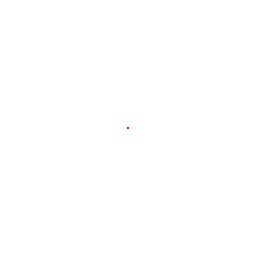

動画を cpm_torch_jp.mp4 に記録します。
map shape  torch.Size([256, 256, 3])


TypeError: 'module' object is not callable

In [4]:
map_tensor = map_init(256,256) # マップを初期化
print("初期マップ（中央部分）:")
imshow_map(map_tensor) # 初期状態を表示

num_epochs = 200      # シミュレーションのエポック数
steps_per_epoch = 1 # 1エポックあたりのCPMステップ数
diffusion_steps = 5 # 1 CPMステップあたりの拡散ステップ数

# オプション: 動画記録用ライターの初期化
video_filename = 'cpm_torch_jp.mp4'
if moviepy_available:
    try:
        writer = LoopWriter(filename=video_filename, fps=10, fade_len=0.5) # ループ動画ライター
        print(f"動画を {video_filename} に記録します。")
        record_video = True
    except Exception as e:
        print(f"動画ライターの初期化に失敗しました: {e}")
        record_video = False
else:
    record_video = False
    print("moviepyが利用できないため、動画は記録されません。")

print("map shape ", map_tensor.shape) # マップの形状を表示
# --- シミュレーション実行 ---
for i in tqdm(range(num_epochs), desc="エポック"):
    for k in tqdm(range(steps_per_epoch), desc="CPMステップ", leave=False):

        # --- 拡散ステップ ---
        # 複数の拡散ステップを実行して密度を平滑化
        #for _ in range(diffusion_steps):
        #     map_tensor = diffusion_step(map_tensor, dt=0.1) # dtは拡散の速さ

        # --- CPM更新ステップ ---
        # チェッカーボードパターンで全セルを更新
        for x_offset in range(3): # x方向オフセット (0 or 1)
            for y_offset in range(3): # y方向オフセット (0 or 1)
                with torch.no_grad():
                  map_tensor, _ = cpm_checkerboard_step(map_tensor, l_A, A_0, l_L, L_0, T,
                                                      x_offset, y_offset)

        # 数値安定性のため、密度が負にならないようにクランプ
        map_tensor[:, :, 1].clamp_(min=0.0)

    # --- 各エポック終了時の可視化 ---
    if ipython_available:
        clear_output(wait=True) # 出力をクリア
    print(f"エポック {i+1}/{num_epochs}")
    print("現在のマップ（中央部分）:")
    #imshow_map(map_tensor[100:150,100:150]) # IDに基づく色表示
    imshow_map(map_tensor)
    print("密度マップ（中央部分、自動範囲）:")
    # imshow_map_area_autoRange(map_tensor[100:156, 100:156, 1]) # 密度表示

    # デバッグ情報（コメントアウト）
    # density_vals = map_tensor[:, :, 1]
    # print(f"密度統計: 最大={density_vals.max().item():.2f}, 最小={density_vals.min().item():.2f}, 合計={density_vals.sum().item():.2f}")

    # --- 動画フレーム追加 ---
    if record_video:
        try:
            frame_rgb = map_tensor_to_rgb(map_tensor) # RGBフレームを取得
            # ライターにフレームを追加（imshowと同様、テンソルを直接渡せるようにヘルパー側で処理）
            writer.add(frame_rgb)
        except Exception as e:
            print(f"フレーム {i+1} の動画への追加中にエラー: {e}")
            record_video = False # エラーが発生したら記録を中止

# --- シミュレーション終了後 ---

# 動画ライターを閉じる
if record_video and writer:
    try:
        writer.close()
        print(f"動画を {video_filename} に保存しました。")
    except Exception as e:
        print(f"動画ライターのクローズ中にエラー: {e}")

# 最終状態を表示
print("\n最終状態のマップ:")
imshow_map(map_tensor)
# imshow_map_area_autoRange(map_tensor[:, :, 1])

print("\nシミュレーション完了。")

# --- END OF FILE CPM_torch_jp.py ---